In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### 导入数据

In [2]:
df3 = pd.read_excel('附件.xlsx',sheet_name='表单3')
df3.head()

,文物编号,表面风化,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
0,A1,无风化,78.45,NaN,NaN,6.08,1.86,7.23,2.15,2.11,NaN,NaN,1.06,0.03,NaN,0.51
1,A2,风化,37.75,NaN,NaN,7.63,NaN,2.33,NaN,NaN,34.30,NaN,14.27,NaN,NaN,NaN
2,A3,无风化,31.95,NaN,1.36,7.19,0.81,2.93,7.06,0.21,39.58,4.69,2.68,0.52,NaN,NaN
3,A4,无风化,35.47,NaN,0.79,2.89,1.05,7.07,6.45,0.96,24.28,8.31,8.45,0.28,NaN,NaN
4,A5,风化,64.29,1.2,0.37,1.64,2.34,12.75,0.81,0.94,12.23,2.16,0.19,0.21,0.49,NaN


In [3]:
df4 = pd.read_excel('附件.xlsx',sheet_name='表单4')
df4 = df4.drop(['文物编号','纹饰','颜色','文物采样点'],axis=1)
df4.head()

,表面风化,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型
0,无风化,69.33,NaN,9.99,6.32,0.87,3.93,1.74,3.87,NaN,NaN,1.17,NaN,NaN,0.39,高钾
1,无风化,87.05,NaN,5.19,2.01,NaN,4.06,NaN,0.78,0.25,NaN,0.66,NaN,NaN,NaN,高钾
2,无风化,61.71,NaN,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,NaN,NaN,高钾
3,无风化,65.88,NaN,9.67,7.12,1.56,6.44,2.06,2.18,NaN,NaN,0.79,NaN,NaN,0.36,高钾
4,无风化,61.58,NaN,10.95,7.35,1.77,7.50,2.62,3.27,NaN,NaN,0.94,0.06,NaN,0.47,高钾


In [4]:
df4.shape

(66, 16)

### 数据预处理

In [5]:
def fill_missing_value(data):
    filled_data = data.copy()
    cols = list(filled_data.columns)
    for col in cols:
        filled_data[col] = filled_data[col].fillna(0)
    return filled_data

def filter_invalid_data(data):
    filtered_data = data.copy()
    cols = list(filtered_data.columns)
    filtered_data['Total'] = filtered_data[cols[1:15]].sum(axis=1)
    filtered_data = filtered_data[(filtered_data['Total'] >= 85) & (filtered_data['Total'] <= 105)]
    return filtered_data
    
def rename_data(data):
    renamed_data = data.copy()
    renamed_data['表面风化'][renamed_data['表面风化'] == '无风化'] = 0
    renamed_data['表面风化'][renamed_data['表面风化'] == '风化'] = 1
    renamed_data = renamed_data.rename(columns={'表面风化':'weathering', 
                              '二氧化硅(SiO2)':'SiO2', 
                              '氧化钠(Na2O)':'Na2O',
                              '氧化钾(K2O)':'K2O',
                              '氧化钙(CaO)':'CaO',
                              '氧化镁(MgO)':'MgO',
                              '氧化铝(Al2O3)':'Al2O3',
                              '氧化铁(Fe2O3)':'Fe2O3',
                              '氧化铜(CuO)':'CuO',
                              '氧化铅(PbO)':'PbO',
                              '氧化钡(BaO)':'BaO',
                              '五氧化二磷(P2O5)':'P2O5',
                              '氧化锶(SrO)':'SrO',
                              '氧化锡(SnO2)':'SnO2',
                              '二氧化硫(SO2)':'SO2'})
    return renamed_data

def process_data_gm(data, pipeline_functions):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [6]:
def process_data_fm(data):
    X = data
    X = process_data_gm(X, [
                            (fill_missing_value, None, None),
                            (filter_invalid_data, None, None),
                            (rename_data, None, None),
                            (select_columns, [# Binary Features
                                              'weathering',
                                              # Numerical Features
                                              'SiO2',
                                              'Na2O',
                                              'K2O',
                                              'CaO',
                                              'MgO',
                                              'Al2O3',
                                              'Fe2O3',
                                              'CuO',
                                              'PbO',
                                              'BaO',
                                              'P2O5',
                                              'SrO',
                                              'SnO2',
                                              'SO2'], None)])
    return X

### 【第二题后半问】- PbBa

In [7]:
df4_pca = pd.read_excel('附件.xlsx',sheet_name='表单4')
df4_pca = df4_pca.drop(['文物编号','纹饰','颜色','文物采样点'],axis=1)
df4_pca_K = df4_pca[df4_pca['类型'] == '高钾']
df4_pca_PbBa = df4_pca[df4_pca['类型'] == '铅钡']

### 降维

##### 原数据

In [9]:
a_PbBa = process_data_fm(df4_pca_PbBa.copy())
a_PbBa = a_PbBa[list(a_PbBa.columns)[1:15]]
a_PbBa.to_csv('a_PbBa.csv')
a_PbBa

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
18,37.36,0.00,0.71,0.00,0.00,5.45,1.51,4.78,9.30,23.55,5.75,0.00,0.00,0.00
19,31.94,0.00,0.00,0.47,0.00,1.59,0.00,8.46,29.14,26.23,0.14,0.91,0.00,0.00
20,34.34,0.00,1.41,4.49,0.98,4.35,2.12,0.00,39.22,10.29,0.00,0.35,0.40,0.00
21,36.93,0.00,0.00,4.24,0.51,3.86,2.74,0.00,37.74,10.35,1.41,0.48,0.44,0.00
22,65.91,0.00,0.00,1.60,0.89,3.11,4.59,0.44,16.55,3.42,1.62,0.30,0.00,0.00
23,69.71,0.00,0.21,0.46,0.00,2.36,1.00,0.11,19.76,4.88,0.17,0.00,0.00,0.00
24,75.51,0.00,0.15,0.64,1.00,2.35,0.00,0.47,16.16,3.55,0.13,0.00,0.00,0.00
25,65.91,0.00,0.00,0.38,0.00,1.44,0.17,0.16,22.05,5.68,0.42,0.00,0.00,0.00
26,60.12,0.00,0.23,0.89,0.00,2.72,0.00,3.01,17.24,10.34,1.46,0.31,0.00,3.66
27,61.28,2.66,0.11,0.84,0.74,5.00,0.00,0.53,15.99,10.96,0.00,0.23,0.00,0.00


##### 主成分分析、不旋转的因子分析、基于最大方差法旋转的因子分析

In [10]:
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler

标准化后数据

In [11]:
X_PbBa = StandardScaler().fit_transform(a_PbBa.copy())
X_PbBa_std = pd.DataFrame(X_PbBa, columns=list(a_PbBa.columns))
X_PbBa_std

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
0,-0.124100,-0.510705,1.942542,-1.246056,-1.057762,0.579132,0.890638,1.187970,-1.610246,1.728725,0.659756,-1.312806,-0.278976,-0.213667
1,-0.425807,-0.510705,-0.645489,-0.957026,-1.057762,-0.713658,-0.709596,2.681727,-0.282866,2.072445,-0.793845,2.158342,-0.278976,-0.213667
2,-0.292210,-0.510705,4.494122,1.515099,0.515337,0.210720,1.537090,-0.752291,0.391529,0.028082,-0.830120,0.022251,1.600440,-0.213667
3,-0.148036,-0.510705,-0.645489,1.361360,-0.239108,0.046610,2.194139,-0.752291,0.292511,0.035777,-0.464777,0.518129,1.788381,-0.213667
4,1.465154,-0.510705,-0.645489,-0.262125,0.370869,-0.204580,4.154691,-0.573689,-1.125190,-0.853020,-0.410364,-0.168471,-0.278976,-0.213667
5,1.676683,-0.510705,0.119985,-0.963176,-1.057762,-0.455770,0.350162,-0.707640,-0.910427,-0.665770,-0.786072,-1.312806,-0.278976,-0.213667
6,1.999544,-0.510705,-0.098722,-0.852484,0.547441,-0.459119,-0.709596,-0.561512,-1.151283,-0.836347,-0.796436,-1.312806,-0.278976,-0.213667
7,1.465154,-0.510705,-0.645489,-1.012372,-1.057762,-0.763896,-0.529437,-0.687345,-0.757217,-0.563167,-0.721294,-1.312806,-0.278976,-0.213667
8,1.142850,-0.510705,0.192887,-0.698744,-1.057762,-0.335199,-0.709596,0.469505,-1.079026,0.034495,-0.451821,-0.130327,-0.278976,1.340659
9,1.207422,0.960567,-0.244526,-0.729492,0.130088,0.428418,-0.709596,-0.537157,-1.162656,0.114012,-0.830120,-0.435483,-0.278976,-0.213667


原变量和降维后变量之间关系（原变量的系数）



 PCA :

[[-0.46979188 -0.20700475 -0.03742938]
 [-0.19859567 -0.26128225 -0.10869341]
 [-0.14391246  0.1260467   0.38739163]
 [ 0.11946902  0.4585387   0.14177792]
 [-0.18262738  0.37651442  0.07502009]
 [-0.35159591  0.1711683   0.29767784]
 [-0.13612467  0.31863083  0.14576712]
 [ 0.3081369  -0.22359356  0.29190096]
 [ 0.33354009  0.25527359 -0.35963245]
 [ 0.30929925 -0.29331731  0.43330732]
 [ 0.24082555  0.34958794  0.00591056]
 [ 0.28479382  0.13410525 -0.03704611]
 [-0.17579047  0.18531173  0.33868595]
 [ 0.23978994 -0.12007371  0.42744701]]


 Unrotated FA :

[[-0.97136411 -0.20318394 -0.11633562]
 [-0.37422     0.04814561 -0.04913099]
 [-0.09666627  0.05232363  0.16089   ]
 [ 0.44879609 -0.12731461  0.6076083 ]
 [-0.06535441 -0.28219409  0.60858707]
 [-0.44307777 -0.08834347  0.53392603]
 [-0.06826953 -0.17793032  0.38989381]
 [ 0.2195883   0.71428944 -0.09195016]
 [ 0.89588094 -0.41257932 -0.15760182]
 [ 0.2241858   0.93820071 -0.25257214]
 [ 0.48795807 -0.01920935  0.66861

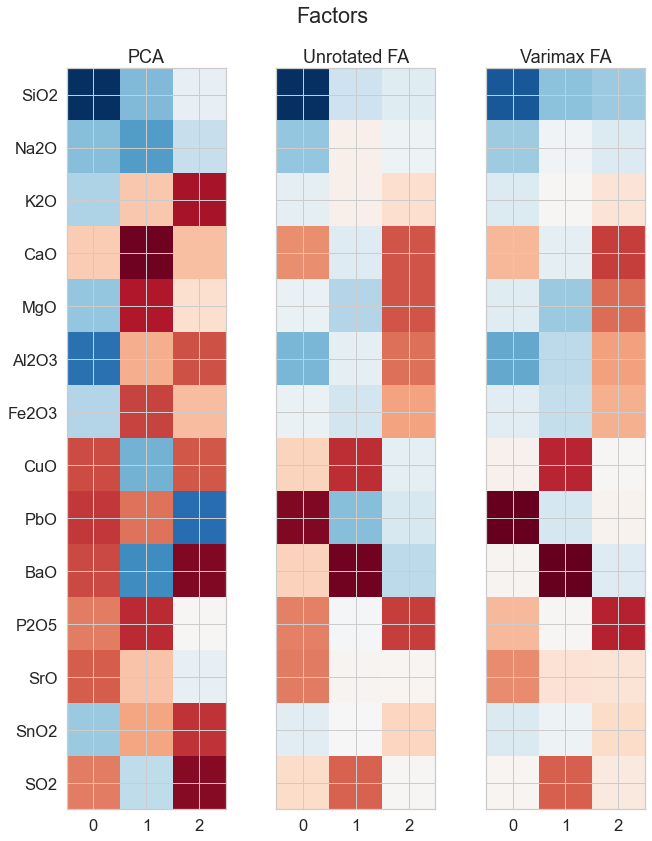

In [12]:
feature_names = list(X_PbBa_std.columns)
n_comps = 3

methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]
fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 12))

i = 0
for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X_PbBa_std)

    components = fa.components_.T
    print("\n\n %s :\n" % method)
    if i == 0:
        components_pca = components
        print(components_pca)
    elif i == 1:
        components_fa = components
        print(components_fa)
    else:
        components_va = components
        print(components_va)
    
    i = i+1
    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    ax.set_xticks([0, 1, 2])
fig.suptitle("Factors")
plt.tight_layout()
plt.show()

新变量

In [13]:
new_a_PbBa_pca = np.dot(a_PbBa, components_pca)
new_a_PbBa_pca

array([[ -6.53178697,  -9.82242944,   9.0082171 ],
       [  5.22395385,  -8.09972511,   2.66700826],
       [ -1.50266198,   4.03174163,  -7.94861912],
       [ -2.47817981,   3.26231688,  -8.14265406],
       [-25.46459842,  -6.8502588 ,  -4.92161677],
       [-25.5153808 ,  -9.82266317,  -6.57302847],
       [-29.76383731, -11.51549474,  -6.03834015],
       [-22.18619643,  -9.09499648,  -7.37918139],
       [-17.93360101, -10.73495732,  -0.50473058],
       [-22.17367007, -11.06735547,  -1.73247375],
       [-16.02099032,  -6.49824356,  -4.93009918],
       [-14.47041541,  -6.91742627,  -6.21967462],
       [-10.14915292,  -4.08523569,  -9.67833438],
       [ -2.58515671,   9.03593293, -15.5214824 ],
       [ 14.26571299,  -6.43288555,   7.22183519],
       [  0.40422417,  -0.16711293,  -1.1438845 ],
       [  4.08051807,   8.15398649, -11.40469873],
       [-17.0650689 , -12.23297514,  -2.43429767],
       [-11.8940852 ,  -3.9366101 ,  -9.534674  ],
       [ 15.06201297,  -6.68193

In [14]:
new_a_PbBa_fa = np.dot(a_PbBa, components_fa)
new_a_PbBa_fa

array([[-21.40999791,  13.25753998,  -4.74218776],
       [  2.851585  ,  11.96418763, -14.46760283],
       [  3.96351811, -15.02821822,  -5.98497106],
       [  1.11409806, -14.88687815,  -5.7995583 ],
       [-48.42234535, -18.26545057,  -5.12806931],
       [-49.73783763, -18.09679175, -10.38972396],
       [-58.74162535, -18.90930379,  -9.90795962],
       [-43.23407759, -17.25987137, -11.24527767],
       [-39.2879896 ,  -5.75402943,  -9.54741075],
       [-45.40363111,  -9.00370257,  -8.94474289],
       [-30.52521245, -12.51928614,  -9.25893716],
       [-27.39718405, -12.11762801,  -9.95739356],
       [-17.12170584, -15.61538382, -11.4152258 ],
       [  7.35104534, -28.23038571,  -3.23597471],
       [ 17.88165754,  21.9149778 , -11.65809598],
       [ -0.44377035,  -1.11465073,  -1.73989239],
       [ 15.5486866 , -17.41791632,  -1.39958284],
       [-36.97107011,  -4.67023619, -11.09365976],
       [-20.18133615, -16.81561324, -10.67931227],
       [ 19.21895636,  22.42660

In [15]:
new_a_PbBa_va = np.dot(a_PbBa, components_va)
new_a_PbBa_va

array([[-22.54904695,   8.4630693 ,  -8.74960922],
       [  2.74570132,  14.03509958, -12.49247607],
       [  8.82150323, -12.8278924 ,  -5.91632949],
       [  6.05740233, -13.37112758,  -6.40437789],
       [-39.97401148, -28.12192919, -17.7730924 ],
       [-40.13627868, -27.59469025, -23.1712091 ],
       [-48.52943524, -30.51287746, -24.90313649],
       [-34.02869809, -25.18117769, -22.39421557],
       [-33.58057007, -13.38677788, -18.99861903],
       [-38.65703973, -18.00674155, -20.0986403 ],
       [-23.66020341, -17.93303295, -17.1128648 ],
       [-20.66131969, -16.73667093, -17.01722667],
       [ -9.76862233, -17.56053639, -16.23274414],
       [ 14.77503562, -25.13442977,  -3.37976921],
       [ 13.80971566,  26.74025003,  -5.49380668],
       [  0.23444044,  -0.95693202,  -1.86973867],
       [ 19.38107439, -13.04765652,   1.11216478],
       [-31.33905164, -11.61149497, -19.86900713],
       [-12.50873513, -19.51638532, -16.33221165],
       [ 15.16479367,  27.67430

##### 根据专业知识（论文）分类降维

In [17]:
def combine(a):
    com = a.copy()
    com['SiO2'] = com['SiO2']+com['P2O5']+com['Al2O3']+com['Fe2O3']+com['PbO']
    com['R2O'] = com['Na2O']+com['K2O']
    com['RO'] = com['CaO']+com['MgO']+com['CuO']+com['BaO']+com['SrO']
    com = com.drop(columns={'Na2O','K2O','CaO','MgO','Al2O3','Fe2O3','CuO','PbO','BaO','P2O5','SrO','SnO2','SO2'})
    return com
com_PbBa = combine(a_PbBa)
com_PbBa

,SiO2,R2O,RO
18,59.37,0.71,28.33
19,62.81,0.00,36.07
20,80.03,1.41,16.11
21,82.68,0.00,15.58
22,91.78,0.00,6.65
23,93.00,0.21,5.45
24,94.15,0.15,5.66
25,89.99,0.00,6.22
26,81.54,0.23,14.55
27,82.27,2.77,13.30


### Kmeans

In [18]:
from sklearn.cluster import KMeans
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
np.random.seed(42)

##### 主成分分析

找到最佳簇数

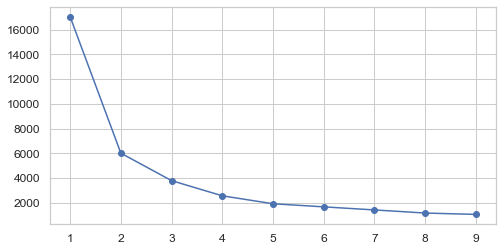

In [19]:
kmeans_per_k = [KMeans(n_clusters = k).fit(new_a_PbBa_pca) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.show()

In [20]:
from sklearn.metrics import silhouette_score
# 通过平均轮廓系数检验得到最佳KMeans聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2到5几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(new_a_PbBa_pca)  # 训练聚类模型
    silhouette_tmp = silhouette_score(new_a_PbBa_pca, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K值对应的轮廓系数:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('最优的K值是:{0} \n对应的轮廓系数是:{1}'.format(best_k, silhouette_int))

*************************K值对应的轮廓系数:*************************
[[2.         0.55691508]
 [3.         0.57400827]
 [4.         0.48640857]]
最优的K值是:3 
对应的轮廓系数是:0.5740082680505918


结果

In [21]:
k = 3
kmeans_PbBa1 = KMeans(n_clusters = k,random_state=42)
y_pred_PbBa1 =  kmeans_PbBa1.fit_predict(new_a_PbBa_pca)
y_pred_PbBa1

array([1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0], dtype=int32)

中心

In [22]:
kmeans_PbBa1.cluster_centers_

array([[  6.18345963,   7.73505451, -12.15061125],
       [-19.44457189,  -7.62126611,  -3.72768763],
       [ 15.05012157,  -5.90944356,   7.52887785]])

评估

In [23]:
kmeans_PbBa1.inertia_

3786.6218865960345

可视化

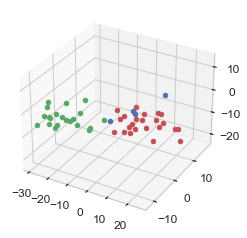

In [24]:
import csv
A = np.array(new_a_PbBa_pca)
num_PbBa, dim_PbBa = new_a_PbBa_pca.shape
color = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
ax = plt.subplot(111, projection='3d')
f = open('result_PbBa_pca.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(f)
for p in range(0,num_PbBa):
    y=y_pred_PbBa1[p]
    csv_writer.writerow([y])
    ax.scatter(int(A[p, 0]), int(A[p, 1]), int(A[p, 2]), c=color[int(y)])
f.close()
plt.show()

含标签数据

In [26]:
a_PbBa = a_PbBa.reset_index()
a_PbBa = a_PbBa.drop(columns=['index'])
cluster_labels_PbBa_2 = pd.DataFrame(y_pred_PbBa1, columns=['clusters'])  
merge_data_PbBa_2 = pd.concat((a_PbBa, cluster_labels_PbBa_2), axis=1)  
merge_data_PbBa_2

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2,clusters
0,37.36,0.00,0.71,0.00,0.00,5.45,1.51,4.78,9.30,23.55,5.75,0.00,0.00,0.00,1
1,31.94,0.00,0.00,0.47,0.00,1.59,0.00,8.46,29.14,26.23,0.14,0.91,0.00,0.00,2
2,34.34,0.00,1.41,4.49,0.98,4.35,2.12,0.00,39.22,10.29,0.00,0.35,0.40,0.00,0
3,36.93,0.00,0.00,4.24,0.51,3.86,2.74,0.00,37.74,10.35,1.41,0.48,0.44,0.00,0
4,65.91,0.00,0.00,1.60,0.89,3.11,4.59,0.44,16.55,3.42,1.62,0.30,0.00,0.00,1
5,69.71,0.00,0.21,0.46,0.00,2.36,1.00,0.11,19.76,4.88,0.17,0.00,0.00,0.00,1
6,75.51,0.00,0.15,0.64,1.00,2.35,0.00,0.47,16.16,3.55,0.13,0.00,0.00,0.00,1
7,65.91,0.00,0.00,0.38,0.00,1.44,0.17,0.16,22.05,5.68,0.42,0.00,0.00,0.00,1
8,60.12,0.00,0.23,0.89,0.00,2.72,0.00,3.01,17.24,10.34,1.46,0.31,0.00,3.66,1
9,61.28,2.66,0.11,0.84,0.74,5.00,0.00,0.53,15.99,10.96,0.00,0.23,0.00,0.00,1


In [63]:
combine(merge_data_PbBa_2)

,SiO2,clusters,R2O,RO
0,59.37,1,0.71,28.33
1,62.81,2,0.00,36.07
2,80.03,0,1.41,16.11
3,82.68,0,0.00,15.58
4,91.78,1,0.00,6.65
5,93.00,1,0.21,5.45
6,94.15,1,0.15,5.66
7,89.99,1,0.00,6.22
8,81.54,1,0.23,14.55
9,82.27,1,2.77,13.30


In [89]:
cluster_labels_K_com = cluster_labels_K_com.rename(columns={'clusters':'manual'})
vo_fa = pd.DataFrame({'vo_fa': y_pred_K_2})
csv = pd.concat([merge_data_PbBa_2,vo_fa,cluster_labels_K_com], axis=1).rename(columns={'clusters':'pca'})
csv.to_csv('对比.csv')

各类别中元素均值

In [27]:
count_list = []
perce_list = []
for i in range(3):
    count = len(merge_data_PbBa_2[merge_data_PbBa_2['clusters'] == i])
    count_list.append(count)
    perce = len(merge_data_PbBa_2[merge_data_PbBa_2['clusters'] == i]) / len(merge_data_PbBa_2)
    perce_list.append(perce)
    
number_pd_PbBa_2 = pd.DataFrame({'counts':count_list,'percentage':perce_list}).T

# 计算各个聚类类别内部最显著特征值
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(3):  # 读取每个类索引
    label_data = merge_data_PbBa_2[merge_data_PbBa_2['clusters'] == line]  # 获得特定类的数据

    part_data = label_data[list(merge_data_PbBa_2.columns)[0:14]] # 获得数值型数据特征
    part_desc = part_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part_desc.iloc[1, :]  # 得到数值型特征的均值

    cluster_features.append(merge_data1)
#  输出完整的类别特征信息
cluster_pd_PbBa_2 = pd.DataFrame(cluster_features, index=[0, 1, 2]).T  # 将列表转化为矩阵
all_cluster_set = pd.concat((number_pd_PbBa_2, cluster_pd_PbBa_2), axis=0)
print('{:*^60}'.format('每个类别主要的特征:'))
print(all_cluster_set)

*************************每个类别主要的特征:*************************
                    0        1          2
counts      23.000000  21.0000   4.000000
percentage   0.479167   0.4375   0.083333
SiO2        26.844000  57.4900  18.898000
Na2O         0.210000   1.8810   0.000000
K2O          0.181000   0.1880   0.100000
CaO          2.907000   1.1420   1.600000
MgO          0.733000   0.7040   0.000000
Al2O3        2.933000   5.0640   1.202000
Fe2O3        0.827000   0.6240   0.000000
CuO          1.367000   1.1650   8.260000
PbO         46.384000  19.8840  29.318000
BaO          8.294000   7.9750  31.290000
P2O5         5.096000   1.1280   3.225000
SrO          0.413000   0.2230   0.588000
SnO2         0.057000   0.0730   0.000000
SO2          0.000000   0.1740   5.122000


最大最小值处理

In [28]:
#各类别数据预处理
from sklearn.preprocessing import MinMaxScaler
model_scaler = MinMaxScaler()
num_sets = cluster_pd_PbBa_2.iloc[:14, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
print(num_sets_max_min)

[[0.2058976  0.11164274 0.92045455 1.         1.         0.44821336
  1.         0.02847075 1.         0.01368218 1.         0.52054795
  0.78082192 0.        ]
 [1.         1.         1.         0.         0.96043656 1.
  0.75453446 0.         0.         0.         0.         0.
  1.         0.03397111]
 [0.         0.         0.         0.25949008 0.         0.
  0.         1.         0.356      1.         0.52847782 1.
  0.         1.        ]]


各类别的显著元素特征

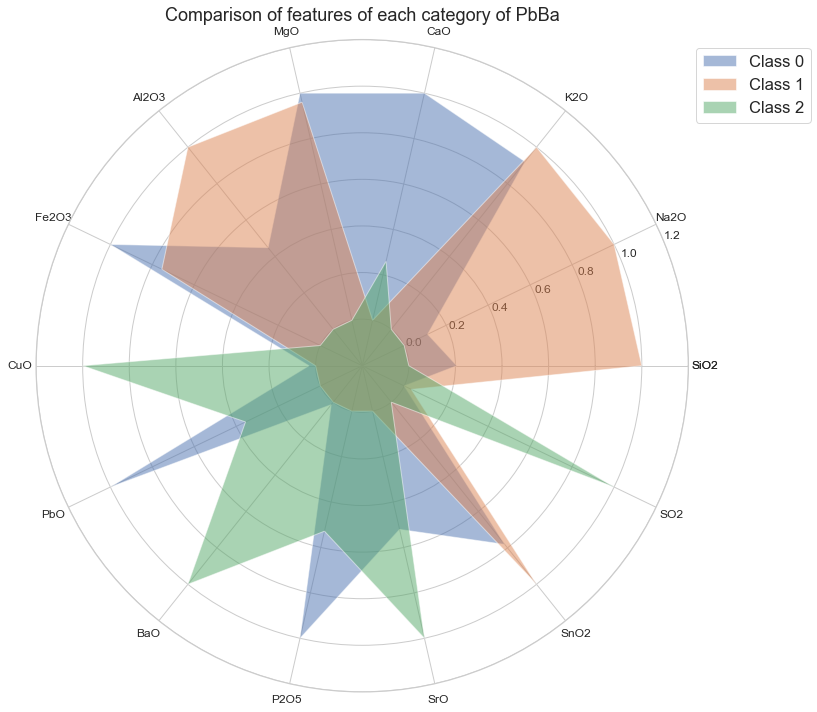

In [32]:
# 画图
fig = plt.figure(figsize=(12,12))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['g', 'r', 'y', 'b','o','PuRd','YlGnBu']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels, [labels[0]]))
# 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
#     ax.plot(angles, data, 'o-', c=cor_list[i], label="第%d类高钾玻璃"%(i))  # 画线
    ax.fill(angles, data,alpha=0.5)
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels)  # 设置极坐标轴
ax.set_title("Comparison of features of each category of PbBa")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(['Class 0', 'Class 1', 'Class 2'], loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # 设置图例位置
# plt.savefig(u'a.png' )
plt.show()

##### 不旋转的因子分析

找到最佳簇数

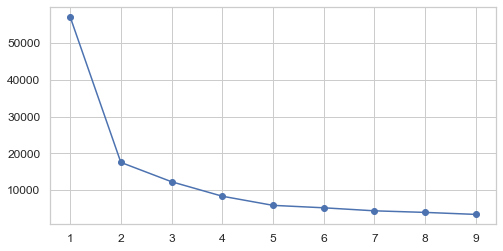

In [30]:
kmeans_per_k = [KMeans(n_clusters = k).fit(new_a_PbBa_fa) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.show()

In [31]:
from sklearn.metrics import silhouette_score
# 通过平均轮廓系数检验得到最佳KMeans聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2到5几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(new_a_PbBa_fa)  # 训练聚类模型
    silhouette_tmp = silhouette_score(new_a_PbBa_fa, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K值对应的轮廓系数:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('最优的K值是:{0} \n对应的轮廓系数是:{1}'.format(best_k, silhouette_int))

*************************K值对应的轮廓系数:*************************
[[2.         0.58467102]
 [3.         0.55833337]
 [4.         0.48940441]]
最优的K值是:2 
对应的轮廓系数是:0.5846710152893947


结果

In [33]:
k = 2
kmeans_K_2 = KMeans(n_clusters = k,random_state=42)
y_pred_K_2 =  kmeans_K_2.fit_predict(new_a_PbBa_fa)
y_pred_K_2

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1], dtype=int32)

中心

In [34]:
kmeans_K_2.cluster_centers_

array([[-37.84251582, -12.28749805,  -7.16102121],
       [ 20.06627547, -11.13795449,  -6.07411712]])

评估

In [35]:
kmeans_K_2.inertia_

17511.86478382238

可视化

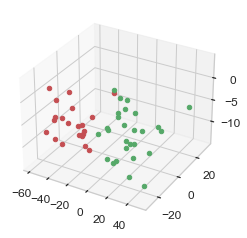

In [36]:
import csv
A = np.array(new_a_PbBa_fa)
num_K_2, dim_K_2 = new_a_PbBa_fa.shape
color = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
ax = plt.subplot(111, projection='3d')
f = open('result_PbBa_2.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(f)
for p in range(0,num_K_2):
    y=y_pred_K_2[p]
    csv_writer.writerow([y])
    ax.scatter(int(A[p, 0]), int(A[p, 1]), int(A[p, 2]), c=color[int(y)])
f.close()
plt.show()

含标签数据

In [37]:
cluster_labels_K_2 = pd.DataFrame(y_pred_K_2, columns=['clusters'])  
merge_data_K_2 = pd.concat((a_PbBa, cluster_labels_K_2), axis=1)  
merge_data_K_2

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2,clusters
0,37.36,0.00,0.71,0.00,0.00,5.45,1.51,4.78,9.30,23.55,5.75,0.00,0.00,0.00,0
1,31.94,0.00,0.00,0.47,0.00,1.59,0.00,8.46,29.14,26.23,0.14,0.91,0.00,0.00,1
2,34.34,0.00,1.41,4.49,0.98,4.35,2.12,0.00,39.22,10.29,0.00,0.35,0.40,0.00,1
3,36.93,0.00,0.00,4.24,0.51,3.86,2.74,0.00,37.74,10.35,1.41,0.48,0.44,0.00,1
4,65.91,0.00,0.00,1.60,0.89,3.11,4.59,0.44,16.55,3.42,1.62,0.30,0.00,0.00,0
5,69.71,0.00,0.21,0.46,0.00,2.36,1.00,0.11,19.76,4.88,0.17,0.00,0.00,0.00,0
6,75.51,0.00,0.15,0.64,1.00,2.35,0.00,0.47,16.16,3.55,0.13,0.00,0.00,0.00,0
7,65.91,0.00,0.00,0.38,0.00,1.44,0.17,0.16,22.05,5.68,0.42,0.00,0.00,0.00,0
8,60.12,0.00,0.23,0.89,0.00,2.72,0.00,3.01,17.24,10.34,1.46,0.31,0.00,3.66,0
9,61.28,2.66,0.11,0.84,0.74,5.00,0.00,0.53,15.99,10.96,0.00,0.23,0.00,0.00,0


各类别中元素均值

In [39]:
count_list = []
perce_list = []
for i in range(2):
    count = len(merge_data_K_2[merge_data_K_2['clusters'] == i])
    count_list.append(count)
    perce = len(merge_data_K_2[merge_data_K_2['clusters'] == i]) / len(merge_data_K_2)
    perce_list.append(perce)
    
number_pd_K_2 = pd.DataFrame({'counts':count_list,'percentage':perce_list}).T

# 计算各个聚类类别内部最显著特征值
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(2):  # 读取每个类索引
    label_data = merge_data_K_2[merge_data_K_2['clusters'] == line]  # 获得特定类的数据

    part_data = label_data[list(merge_data_K_2.columns)[0:14]] # 获得数值型数据特征
    part_desc = part_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part_desc.iloc[1, :]  # 得到数值型特征的均值

    cluster_features.append(merge_data1)
#  输出完整的类别特征信息
cluster_pd_K_2 = pd.DataFrame(cluster_features, index=[0, 1]).T  # 将列表转化为矩阵
all_cluster_set = pd.concat((number_pd_K_2, cluster_pd_K_2), axis=0)
print('{:*^60}'.format('每个类别主要的特征:'))
print(all_cluster_set)

*************************每个类别主要的特征:*************************
                  0        1
counts      21.0000  27.0000
percentage   0.4375   0.5625
SiO2        57.4900  25.6670
Na2O         1.8810   0.1790
K2O          0.1880   0.1690
CaO          1.1420   2.7140
MgO          0.7040   0.6240
Al2O3        5.0640   2.6760
Fe2O3        0.6240   0.7050
CuO          1.1650   2.3890
PbO         19.8840  43.8560
BaO          7.9750  11.7010
P2O5         1.1280   4.8190
SrO          0.2230   0.4390
SnO2         0.0730   0.0490
SO2          0.1740   0.7590


最大最小值处理

In [40]:
#各类别数据预处理
from sklearn.preprocessing import MinMaxScaler
model_scaler = MinMaxScaler()
num_sets = cluster_pd_K_2.iloc[:14, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
print(num_sets_max_min)

[[1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.]]


各类别的显著元素特征

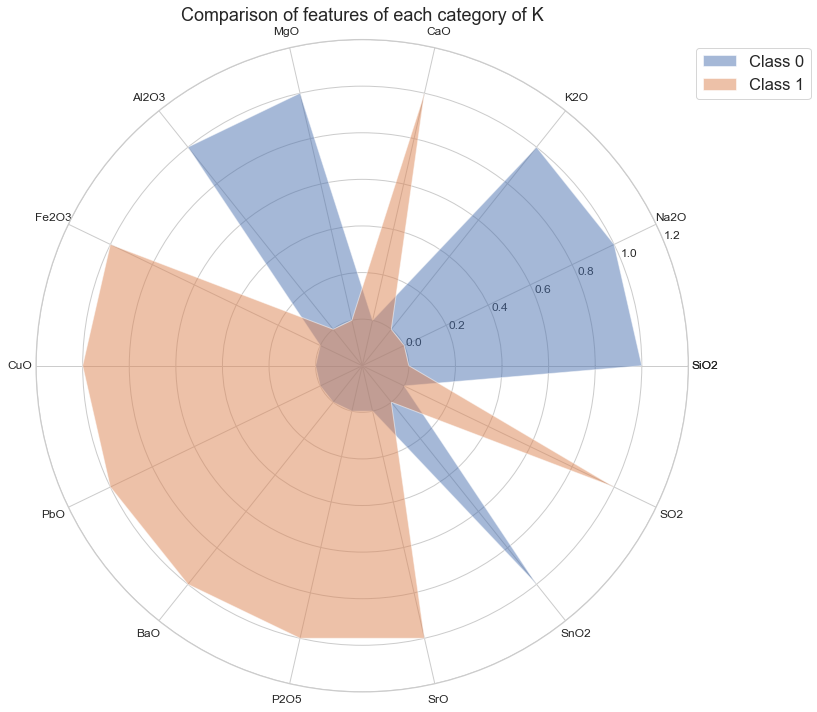

In [41]:
# 画图
fig = plt.figure(figsize=(12,12))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['g', 'r', 'y', 'b','o','PuRd','YlGnBu']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels, [labels[0]]))
# 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
#     ax.plot(angles, data, 'o-', c=cor_list[i], label="第%d类高钾玻璃"%(i))  # 画线
    ax.fill(angles, data,alpha=0.5)
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels)  # 设置极坐标轴
ax.set_title("Comparison of features of each category of K")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(['Class 0', 'Class 1'], loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # 设置图例位置
# plt.savefig(u'a.png' )
plt.show()

##### 基于最大方差旋转的因子分析

找到最佳簇数

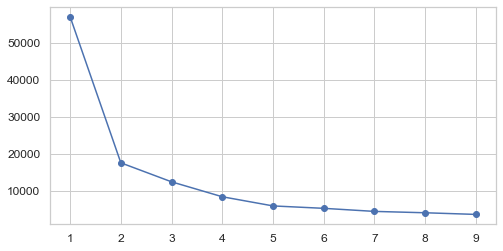

In [42]:
kmeans_per_k = [KMeans(n_clusters = k).fit(new_a_PbBa_va) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.show()

In [43]:
from sklearn.metrics import silhouette_score
# 通过平均轮廓系数检验得到最佳KMeans聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2到5几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(new_a_PbBa_va)  # 训练聚类模型
    silhouette_tmp = silhouette_score(new_a_PbBa_va, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K值对应的轮廓系数:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('最优的K值是:{0} \n对应的轮廓系数是:{1}'.format(best_k, silhouette_int))

*************************K值对应的轮廓系数:*************************
[[2.         0.58467102]
 [3.         0.55833337]
 [4.         0.48940441]]
最优的K值是:2 
对应的轮廓系数是:0.5846710152893947


结果

In [44]:
k = 2
kmeans_K_2 = KMeans(n_clusters = k,random_state=42)
y_pred_K_2 =  kmeans_K_2.fit_predict(new_a_PbBa_va)
y_pred_K_2

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1], dtype=int32)

中心

In [45]:
kmeans_K_2.cluster_centers_

array([[-31.07095021, -19.66033083, -16.80435304],
       [ 23.05036316,  -5.35544834,  -1.89849193]])

评估

In [46]:
kmeans_K_2.inertia_

17511.86478382238

可视化

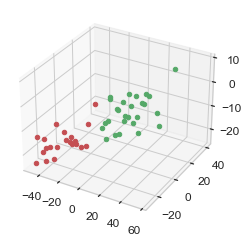

In [47]:
import csv
A = np.array(new_a_PbBa_va)
num_K_2, dim_K_2 = new_a_PbBa_va.shape
color = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
ax = plt.subplot(111, projection='3d')
f = open('result_K_2.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(f)
for p in range(0,num_K_2):
    y=y_pred_K_2[p]
    csv_writer.writerow([y])
    ax.scatter(int(A[p, 0]), int(A[p, 1]), int(A[p, 2]), c=color[int(y)])
f.close()
plt.show()

含标签数据

In [48]:
cluster_labels_K_2 = pd.DataFrame(y_pred_K_2, columns=['clusters'])  
merge_data_K_2 = pd.concat((a_PbBa, cluster_labels_K_2), axis=1)  
merge_data_K_2

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2,clusters
0,37.36,0.00,0.71,0.00,0.00,5.45,1.51,4.78,9.30,23.55,5.75,0.00,0.00,0.00,0
1,31.94,0.00,0.00,0.47,0.00,1.59,0.00,8.46,29.14,26.23,0.14,0.91,0.00,0.00,1
2,34.34,0.00,1.41,4.49,0.98,4.35,2.12,0.00,39.22,10.29,0.00,0.35,0.40,0.00,1
3,36.93,0.00,0.00,4.24,0.51,3.86,2.74,0.00,37.74,10.35,1.41,0.48,0.44,0.00,1
4,65.91,0.00,0.00,1.60,0.89,3.11,4.59,0.44,16.55,3.42,1.62,0.30,0.00,0.00,0
5,69.71,0.00,0.21,0.46,0.00,2.36,1.00,0.11,19.76,4.88,0.17,0.00,0.00,0.00,0
6,75.51,0.00,0.15,0.64,1.00,2.35,0.00,0.47,16.16,3.55,0.13,0.00,0.00,0.00,0
7,65.91,0.00,0.00,0.38,0.00,1.44,0.17,0.16,22.05,5.68,0.42,0.00,0.00,0.00,0
8,60.12,0.00,0.23,0.89,0.00,2.72,0.00,3.01,17.24,10.34,1.46,0.31,0.00,3.66,0
9,61.28,2.66,0.11,0.84,0.74,5.00,0.00,0.53,15.99,10.96,0.00,0.23,0.00,0.00,0


各类别中元素均值

In [49]:
count_list = []
perce_list = []
for i in range(2):
    count = len(merge_data_K_2[merge_data_K_2['clusters'] == i])
    count_list.append(count)
    perce = len(merge_data_K_2[merge_data_K_2['clusters'] == i]) / len(merge_data_K_2)
    perce_list.append(perce)
    
number_pd_K_2 = pd.DataFrame({'counts':count_list,'percentage':perce_list}).T

# 计算各个聚类类别内部最显著特征值
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(2):  # 读取每个类索引
    label_data = merge_data_K_2[merge_data_K_2['clusters'] == line]  # 获得特定类的数据

    part_data = label_data[list(merge_data_K_2.columns)[0:14]] # 获得数值型数据特征
    part_desc = part_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part_desc.iloc[1, :]  # 得到数值型特征的均值

    cluster_features.append(merge_data1)
#  输出完整的类别特征信息
cluster_pd_K_2 = pd.DataFrame(cluster_features, index=[0, 1]).T  # 将列表转化为矩阵
all_cluster_set = pd.concat((number_pd_K_2, cluster_pd_K_2), axis=0)
print('{:*^60}'.format('每个类别主要的特征:'))
print(all_cluster_set)

*************************每个类别主要的特征:*************************
                  0        1
counts      21.0000  27.0000
percentage   0.4375   0.5625
SiO2        57.4900  25.6670
Na2O         1.8810   0.1790
K2O          0.1880   0.1690
CaO          1.1420   2.7140
MgO          0.7040   0.6240
Al2O3        5.0640   2.6760
Fe2O3        0.6240   0.7050
CuO          1.1650   2.3890
PbO         19.8840  43.8560
BaO          7.9750  11.7010
P2O5         1.1280   4.8190
SrO          0.2230   0.4390
SnO2         0.0730   0.0490
SO2          0.1740   0.7590


最大最小值处理

In [50]:
#各类别数据预处理
from sklearn.preprocessing import MinMaxScaler
model_scaler = MinMaxScaler()
num_sets = cluster_pd_K_2.iloc[:14, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
print(num_sets_max_min)

[[1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.]]


各类别的显著元素特征

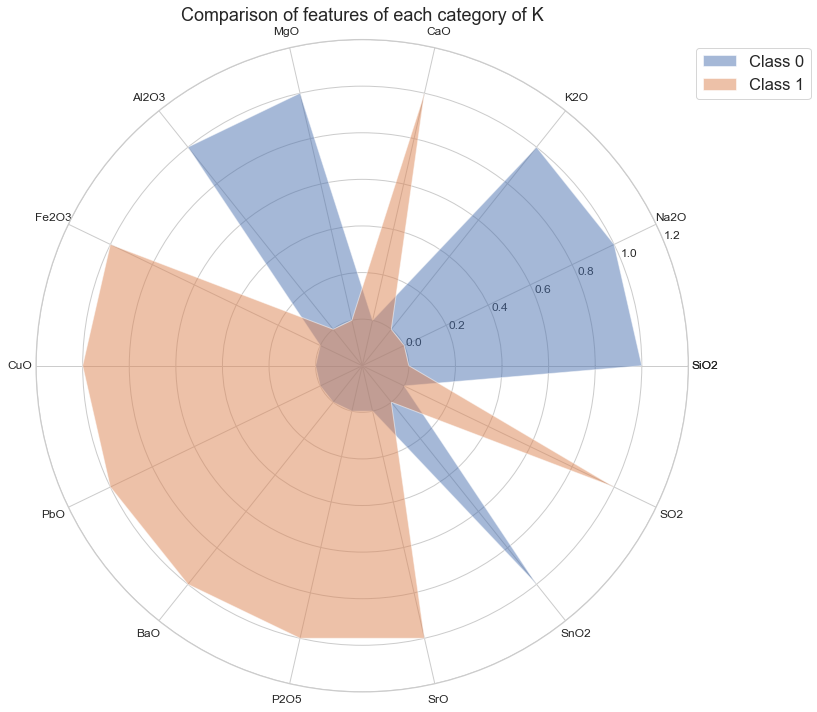

In [51]:
# 画图
fig = plt.figure(figsize=(12,12))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['g', 'r', 'y', 'b','o','PuRd','YlGnBu']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels, [labels[0]]))
# 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
#     ax.plot(angles, data, 'o-', c=cor_list[i], label="第%d类高钾玻璃"%(i))  # 画线
    ax.fill(angles, data,alpha=0.5)
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels)  # 设置极坐标轴
ax.set_title("Comparison of features of each category of K")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(['Class 0', 'Class 1'], loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # 设置图例位置
# plt.savefig(u'a.png' )
plt.show()

##### 根据专业知识（论文）分类降维

找到最佳簇数

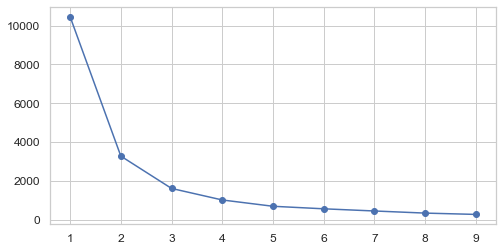

In [52]:
kmeans_per_k = [KMeans(n_clusters = k).fit(com_PbBa) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.show()

In [53]:
from sklearn.metrics import silhouette_score
# 通过平均轮廓系数检验得到最佳KMeans聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2到5几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(com_PbBa)  # 训练聚类模型
    silhouette_tmp = silhouette_score(com_PbBa, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K值对应的轮廓系数:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('最优的K值是:{0} \n对应的轮廓系数是:{1}'.format(best_k, silhouette_int))

*************************K值对应的轮廓系数:*************************
[[2.         0.72962261]
 [3.         0.46779479]
 [4.         0.50392421]]
最优的K值是:2 
对应的轮廓系数是:0.7296226051192547


结果

In [54]:
k_com = 2
kmeans_K_com = KMeans(n_clusters = k_com,random_state=42)
y_pred_K_com =  kmeans_K_com.fit_predict(com_PbBa)
y_pred_K_com

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

中心

In [55]:
kmeans_K_com.cluster_centers_

array([[83.64023256,  1.20255814, 12.15116279],
       [53.988     ,  0.222     , 39.056     ]])

评估

In [56]:
kmeans_K_com.inertia_

3271.2278381395345

可视化

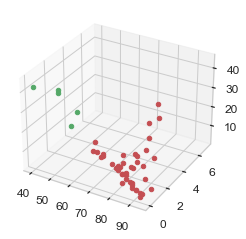

In [57]:
import csv
A = np.array(com_PbBa)
num_K_com, dim_K_com = com_PbBa.shape
color = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
ax = plt.subplot(111, projection='3d')
f = open('result_K_com.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(f)
for p in range(0,num_K_com):
    y=y_pred_K_com[p]
    csv_writer.writerow([y])
    ax.scatter(int(A[p, 0]), int(A[p, 1]), int(A[p, 2]), c=color[int(y)], alpha=1)
f.close()
plt.show()

含标签数据

In [59]:
com_PbBa = com_PbBa.reset_index()
com_PbBa = com_PbBa.drop(columns=['index'])
cluster_labels_K_com = pd.DataFrame(y_pred_K_com, columns=['clusters'])  
merge_data_K_com = pd.concat((com_PbBa, cluster_labels_K_com), axis=1)  
merge_data_K_com

,SiO2,R2O,RO,clusters
0,59.37,0.71,28.33,1
1,62.81,0.00,36.07,1
2,80.03,1.41,16.11,0
3,82.68,0.00,15.58,0
4,91.78,0.00,6.65,0
5,93.00,0.21,5.45,0
6,94.15,0.15,5.66,0
7,89.99,0.00,6.22,0
8,81.54,0.23,14.55,0
9,82.27,2.77,13.30,0


各类别中元素均值

In [60]:
count_list = []
perce_list = []
for i in range(2):
    count = len(merge_data_K_com[merge_data_K_com['clusters'] == i])
    count_list.append(count)
    perce = len(merge_data_K_com[merge_data_K_com['clusters'] == i]) / len(merge_data_K_com)
    perce_list.append(perce)
    
number_pd_K_com = pd.DataFrame({'counts':count_list,'percentage':perce_list}).T

# 计算各个聚类类别内部最显著特征值
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(2):  # 读取每个类索引
    label_data = merge_data_K_com[merge_data_K_com['clusters'] == line]  # 获得特定类的数据

    part_data = label_data[list(merge_data_K_com.columns)[0:3]] # 获得数值型数据特征
    part_desc = part_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part_desc.iloc[1, :]  # 得到数值型特征的均值

    cluster_features.append(merge_data1)
#  输出完整的类别特征信息
cluster_pd_K_com = pd.DataFrame(cluster_features, index=[0, 1]).T  # 将列表转化为矩阵
all_cluster_set = pd.concat((number_pd_K_com, cluster_pd_K_com), axis=0)
print('{:*^60}'.format('每个类别主要的特征:'))
print(all_cluster_set)

*************************每个类别主要的特征:*************************
                    0          1
counts      43.000000   5.000000
percentage   0.895833   0.104167
SiO2        83.640000  53.988000
R2O          1.203000   0.222000
RO          12.151000  39.056000


最大最小值处理

In [61]:
#各类别数据预处理
from sklearn.preprocessing import MinMaxScaler
model_scaler = MinMaxScaler()
num_sets = cluster_pd_K_com.iloc[:3, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
print(num_sets_max_min)

[[1. 1. 0.]
 [0. 0. 1.]]


各类别的显著元素特征

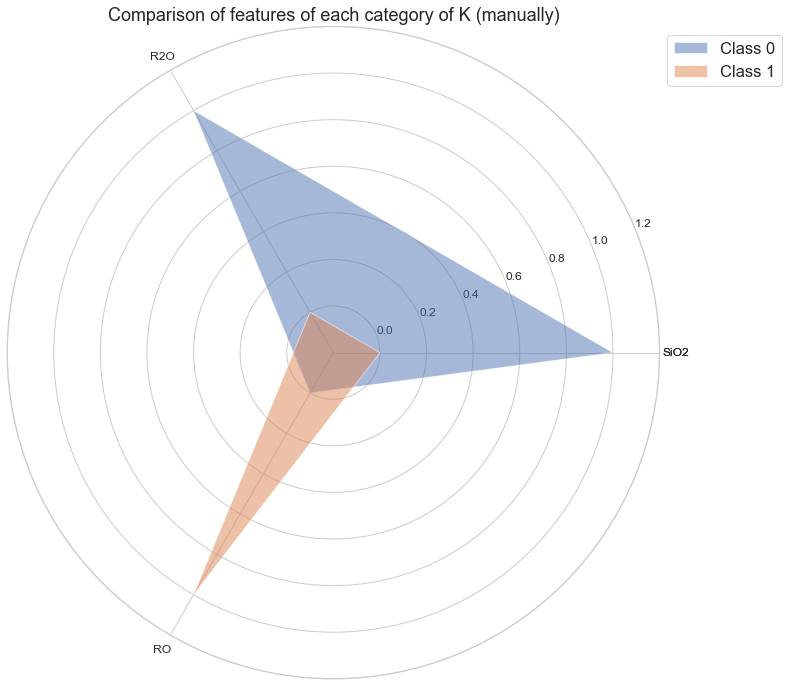

In [62]:
# 画图
fig = plt.figure(figsize=(12,12))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['g', 'r', 'y', 'b','o','PuRd','YlGnBu']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels, [labels[0]]))
# 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
#     ax.plot(angles, data, 'o-', c=cor_list[i], label="第%d类高钾玻璃"%(i))  # 画线
    ax.fill(angles, data,alpha=0.5)
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels)  # 设置极坐标轴
ax.set_title("Comparison of features of each category of K (manually)")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(['Class 0', 'Class 1'], loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # 设置图例位置
# plt.savefig(u'a.png' )
plt.show()

### 可靠性分析（选用PCA进行降维：inertia_=3000+, 轮廓系数=0.57）

In [66]:
kmeans_K_com_1 = KMeans(n_clusters = 3,random_state=42,init='random')
y_pred_K_com_1 =  kmeans_K_com_1.fit_predict(new_a_PbBa_pca)
y_pred_K_com_1

array([0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 2, 2, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1], dtype=int32)

In [65]:
y_pred_PbBa1

array([1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0], dtype=int32)

In [67]:
kmeans_K_com_2 = KMeans(n_clusters = 3,random_state=42,algorithm='elkan')
y_pred_K_com_2 =  kmeans_K_com_2.fit_predict(new_a_PbBa_pca)
y_pred_K_com_2

array([1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0], dtype=int32)

In [68]:
kmeans_K_com_3 = KMeans(n_clusters = 3,random_state=42,algorithm='auto')
y_pred_K_com_3 =  kmeans_K_com_3.fit_predict(new_a_PbBa_pca)
y_pred_K_com_3

array([1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0], dtype=int32)

In [69]:
kmeans_K_com_4 = KMeans(n_clusters = 3,random_state=42,algorithm='full')
y_pred_K_com_4 =  kmeans_K_com_4.fit_predict(new_a_PbBa_pca)
y_pred_K_com_4

array([1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0], dtype=int32)

### 敏感性分析（选用PCA进行降维：inertia_=3000+, 轮廓系数=0.57）

In [96]:
a_PbBa_jittered = a_PbBa.copy()
a_PbBa_jittered

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
0,37.36,0.00,0.71,0.00,0.00,5.45,1.51,4.78,9.30,23.55,5.75,0.00,0.00,0.00
1,31.94,0.00,0.00,0.47,0.00,1.59,0.00,8.46,29.14,26.23,0.14,0.91,0.00,0.00
2,34.34,0.00,1.41,4.49,0.98,4.35,2.12,0.00,39.22,10.29,0.00,0.35,0.40,0.00
3,36.93,0.00,0.00,4.24,0.51,3.86,2.74,0.00,37.74,10.35,1.41,0.48,0.44,0.00
4,65.91,0.00,0.00,1.60,0.89,3.11,4.59,0.44,16.55,3.42,1.62,0.30,0.00,0.00
5,69.71,0.00,0.21,0.46,0.00,2.36,1.00,0.11,19.76,4.88,0.17,0.00,0.00,0.00
6,75.51,0.00,0.15,0.64,1.00,2.35,0.00,0.47,16.16,3.55,0.13,0.00,0.00,0.00
7,65.91,0.00,0.00,0.38,0.00,1.44,0.17,0.16,22.05,5.68,0.42,0.00,0.00,0.00
8,60.12,0.00,0.23,0.89,0.00,2.72,0.00,3.01,17.24,10.34,1.46,0.31,0.00,3.66
9,61.28,2.66,0.11,0.84,0.74,5.00,0.00,0.53,15.99,10.96,0.00,0.23,0.00,0.00


In [97]:
col_list_in = []
row_list_in = []
col_list_de = []
row_list_de = []
import random
for i in range(200):
    col_list_in.append(random.randint(0,13))
    row_list_in.append(random.randint(0,47))
for i in range(200):
    col_list_de.append(random.randint(0,13))
    row_list_de.append(random.randint(0,47))
tuple_list_in = list(zip(row_list_in, col_list_in))
tuple_list_de = list(zip(row_list_de, col_list_de))

In [98]:
for coordinate in tuple_list_in:
    if coordinate[1] == 1 or coordinate[1] == 9:
        a_PbBa_jittered.iloc[coordinate] = a_PbBa_jittered.iloc[coordinate] * 1.05
    else:
        a_PbBa_jittered.iloc[coordinate] = a_PbBa_jittered.iloc[coordinate] * 1.05
for coordinate in tuple_list_de:
    if coordinate[1] == 1 or coordinate[1] == 9:
        a_PbBa_jittered.iloc[coordinate] = a_PbBa_jittered.iloc[coordinate] / 1.05
    else:
        a_PbBa_jittered.iloc[coordinate] = a_PbBa_jittered.iloc[coordinate] / 1.05
cols = list(a_PbBa_jittered.columns)[0:14]
a_PbBa_jittered['total'] = a_PbBa_jittered[cols].sum(axis=1)
a_PbBa_jittered

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2,total
0,37.360000,0.000000,0.710000,0.000000,0.000000,5.722500,1.510000,4.552381,9.765000,23.550000,5.476190,0.000000,0.0000,0.0000,88.646071
1,31.940000,0.000000,0.000000,0.470000,0.000000,1.590000,0.000000,8.460000,29.140000,27.541500,0.140000,0.866667,0.0000,0.0000,100.148167
2,36.057000,0.000000,1.410000,4.490000,0.980000,4.567500,2.226000,0.000000,39.220000,10.804500,0.000000,0.350000,0.4000,0.0000,100.505000
3,38.776500,0.000000,0.000000,4.240000,0.485714,3.860000,2.740000,0.000000,41.608350,10.350000,1.410000,0.480000,0.4620,0.0000,104.412564
4,69.205500,0.000000,0.000000,1.600000,0.890000,2.961905,4.590000,0.440000,17.377500,3.420000,1.620000,0.300000,0.0000,0.0000,102.404905
5,73.195500,0.000000,0.210000,0.460000,0.000000,2.478000,1.050000,0.104762,17.922902,4.647619,0.170000,0.000000,0.0000,0.0000,100.238783
6,75.510000,0.000000,0.150000,0.609524,1.000000,2.238095,0.000000,0.470000,16.160000,3.550000,0.117914,0.000000,0.0000,0.0000,99.805533
7,65.910000,0.000000,0.000000,0.399000,0.000000,1.371429,0.170000,0.176400,22.050000,5.680000,0.463050,0.000000,0.0000,0.0000,96.219879
8,57.257143,0.000000,0.219048,0.981225,0.000000,2.720000,0.000000,2.866667,17.240000,10.340000,1.533000,0.310000,0.0000,3.6600,97.127082
9,61.280000,2.660000,0.110000,0.840000,0.740000,5.000000,0.000000,0.504762,16.789500,10.438095,0.000000,0.230000,0.0000,0.0000,98.592357


标准化后数据

In [99]:
a_PbBa_jittered = a_PbBa_jittered.drop(columns={'total'})
X_PbBa_jittered = StandardScaler().fit_transform(a_PbBa_jittered.copy())
X_PbBa_jittered_std = pd.DataFrame(X_PbBa, columns=list(a_PbBa_jittered.columns))
X_PbBa_jittered_std

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
0,-0.124100,-0.510705,1.942542,-1.246056,-1.057762,0.579132,0.890638,1.187970,-1.610246,1.728725,0.659756,-1.312806,-0.278976,-0.213667
1,-0.425807,-0.510705,-0.645489,-0.957026,-1.057762,-0.713658,-0.709596,2.681727,-0.282866,2.072445,-0.793845,2.158342,-0.278976,-0.213667
2,-0.292210,-0.510705,4.494122,1.515099,0.515337,0.210720,1.537090,-0.752291,0.391529,0.028082,-0.830120,0.022251,1.600440,-0.213667
3,-0.148036,-0.510705,-0.645489,1.361360,-0.239108,0.046610,2.194139,-0.752291,0.292511,0.035777,-0.464777,0.518129,1.788381,-0.213667
4,1.465154,-0.510705,-0.645489,-0.262125,0.370869,-0.204580,4.154691,-0.573689,-1.125190,-0.853020,-0.410364,-0.168471,-0.278976,-0.213667
5,1.676683,-0.510705,0.119985,-0.963176,-1.057762,-0.455770,0.350162,-0.707640,-0.910427,-0.665770,-0.786072,-1.312806,-0.278976,-0.213667
6,1.999544,-0.510705,-0.098722,-0.852484,0.547441,-0.459119,-0.709596,-0.561512,-1.151283,-0.836347,-0.796436,-1.312806,-0.278976,-0.213667
7,1.465154,-0.510705,-0.645489,-1.012372,-1.057762,-0.763896,-0.529437,-0.687345,-0.757217,-0.563167,-0.721294,-1.312806,-0.278976,-0.213667
8,1.142850,-0.510705,0.192887,-0.698744,-1.057762,-0.335199,-0.709596,0.469505,-1.079026,0.034495,-0.451821,-0.130327,-0.278976,1.340659
9,1.207422,0.960567,-0.244526,-0.729492,0.130088,0.428418,-0.709596,-0.537157,-1.162656,0.114012,-0.830120,-0.435483,-0.278976,-0.213667


原变量和降维后变量之间关系（原变量的系数）



 PCA :

[[-0.46979188 -0.20700475 -0.03742938]
 [-0.19859567 -0.26128225 -0.10869341]
 [-0.14391246  0.1260467   0.38739163]
 [ 0.11946902  0.4585387   0.14177792]
 [-0.18262738  0.37651442  0.07502009]
 [-0.35159591  0.1711683   0.29767784]
 [-0.13612467  0.31863083  0.14576712]
 [ 0.3081369  -0.22359356  0.29190096]
 [ 0.33354009  0.25527359 -0.35963245]
 [ 0.30929925 -0.29331731  0.43330732]
 [ 0.24082555  0.34958794  0.00591056]
 [ 0.28479382  0.13410525 -0.03704611]
 [-0.17579047  0.18531173  0.33868595]
 [ 0.23978994 -0.12007371  0.42744701]]


 Unrotated FA :

[[-0.97136411 -0.20318394 -0.11633562]
 [-0.37422     0.04814561 -0.04913099]
 [-0.09666627  0.05232363  0.16089   ]
 [ 0.44879609 -0.12731461  0.6076083 ]
 [-0.06535441 -0.28219409  0.60858707]
 [-0.44307777 -0.08834347  0.53392603]
 [-0.06826953 -0.17793032  0.38989381]
 [ 0.2195883   0.71428944 -0.09195016]
 [ 0.89588094 -0.41257932 -0.15760182]
 [ 0.2241858   0.93820071 -0.25257214]
 [ 0.48795807 -0.01920935  0.66861

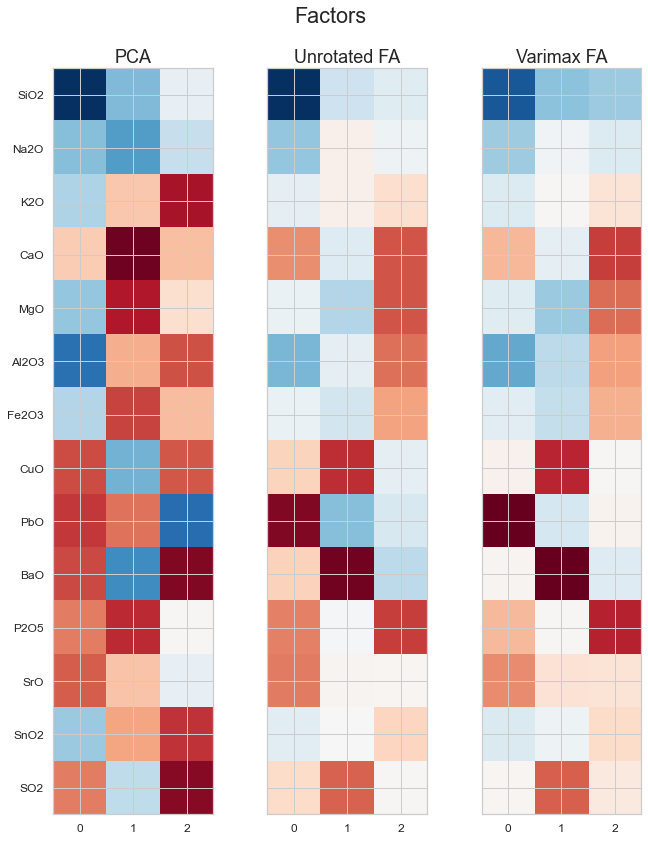

In [100]:
feature_names = list(X_PbBa_jittered_std.columns)
n_comps = 3

methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]
fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 12))

i = 0
for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X_PbBa_jittered_std)

    components = fa.components_.T
    print("\n\n %s :\n" % method)
    if i == 0:
        components_pca_ = components
        print(components_pca_)
    elif i == 1:
        components_fa_ = components
        print(components_fa_)
    else:
        components_va_ = components
        print(components_va_)
    
    i = i+1
    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    ax.set_xticks([0, 1, 2])
fig.suptitle("Factors")
plt.tight_layout()
plt.show()

选用基于最大方差旋转的因子分析（最后一个），得到新变量

In [101]:
new_a_PbBa_jittered_pca = np.dot(a_PbBa_jittered, components_pca_)
new_a_PbBa_jittered_pca

array([[ -6.60857887,  -9.70191021,   8.85404463],
       [  5.61725875,  -8.49022199,   3.23689615],
       [ -2.24106149,   3.59640669,  -7.7097525 ],
       [ -2.05483288,   3.86250313,  -9.5973224 ],
       [-26.68472344,  -7.34655327,  -5.3866458 ],
       [-27.8873699 , -10.90767873,  -6.10261572],
       [-29.73104367, -11.55284898,  -6.076044  ],
       [-22.1443961 ,  -9.08663867,  -7.39185818],
       [-16.60276526, -10.04431428,  -0.43029246],
       [-22.07620631, -10.70453746,  -2.25351207],
       [-16.97321864,  -6.71925733,  -5.40878015],
       [-14.77258606,  -7.08551356,  -5.72738994],
       [ -9.57451764,  -3.63133751, -10.25626276],
       [ -1.90504504,   9.43958538, -15.35956479],
       [ 13.85088469,  -5.99690978,   6.55549666],
       [  0.55215558,   0.17599492,  -2.18738613],
       [  4.0844161 ,   8.27644898, -11.64190832],
       [-16.93353702, -12.51049085,  -2.23697326],
       [-13.50084855,  -4.93479864,  -8.93197193],
       [ 15.05611497,  -6.67292

In [103]:
k = 3
kmeans_K = KMeans(n_clusters = k,random_state=42)
y_pred_K =  kmeans_K.fit_predict(new_a_PbBa_jittered_pca)
y_pred_K

array([1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0], dtype=int32)

In [104]:
k = 3
kmeans_PbBa1 = KMeans(n_clusters = k,random_state=42)
y_pred_PbBa1 =  kmeans_PbBa1.fit_predict(new_a_PbBa_pca)
y_pred_PbBa1

array([1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0], dtype=int32)

结果不变